In [1]:
!pip install torch torchvision

In [2]:
!pip install -U d2l

     |████████████████████████████████| 82 kB 555 kB/s 
     |████████████████████████████████| 11.2 MB 37.6 MB/s 
     |████████████████████████████████| 9.9 MB 62.7 MB/s 
     |████████████████████████████████| 61 kB 6.2 MB/s 
     |████████████████████████████████| 900 kB 41.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

## Polynomial Regression

In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Generating the Dataset

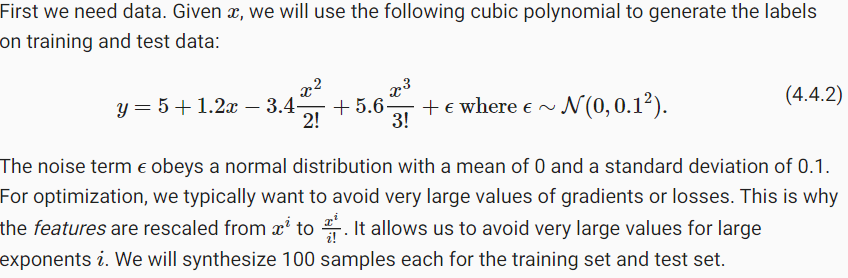

In [4]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

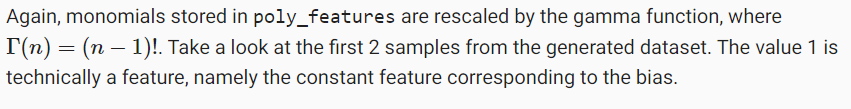

In [5]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7494],
         [ 0.8415]]),
 tensor([[ 1.0000e+00, -7.4936e-01,  2.8077e-01, -7.0132e-02,  1.3138e-02,
          -1.9691e-03,  2.4592e-04, -2.6326e-05,  2.4660e-06, -2.0532e-07,
           1.5386e-08, -1.0481e-09,  6.5453e-11, -3.7729e-12,  2.0195e-13,
          -1.0089e-14,  4.7250e-16, -2.0828e-17,  8.6707e-19, -3.4197e-20],
         [ 1.0000e+00,  8.4154e-01,  3.5409e-01,  9.9328e-02,  2.0897e-02,
           3.5171e-03,  4.9330e-04,  5.9305e-05,  6.2384e-06,  5.8332e-07,
           4.9089e-08,  3.7554e-09,  2.6336e-10,  1.7048e-11,  1.0248e-12,
           5.7493e-14,  3.0239e-15,  1.4969e-16,  6.9984e-18,  3.0997e-19]]),
 tensor([2.7717, 5.4684]))

## Training and Testing the Model

In [7]:
# Let us first implement a function to evaluate the loss on a given dataset

def evaluate_loss(net, data_iter, loss):  #save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [8]:
# Now define the training function.

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## Third-Order Polynomial Function Fitting (Normal)

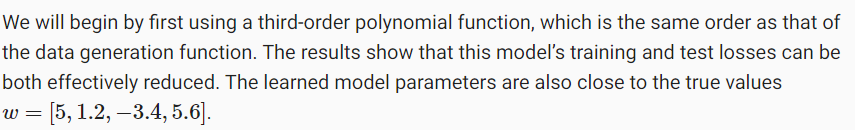

In [ ]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

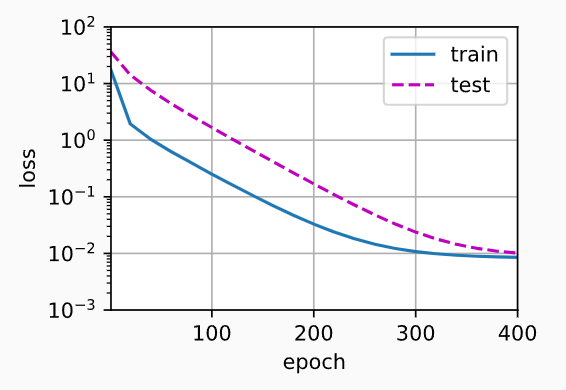

 ## Linear Function Fitting (Underfitting)

In [ ]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

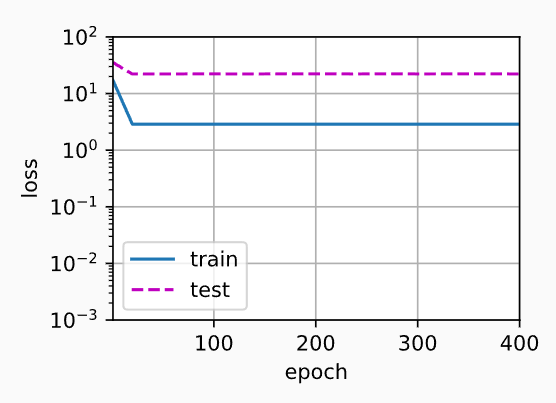

## Higher-Order Polynomial Function Fitting (Overfitting)

Now let us try to train the model using a polynomial of too high degree. Here, there are insufficient data to learn that the higher-degree coefficients should have values close to zero. As a result, our overly-complex model is so susceptible that it is being influenced by noise in the training data. Though the training loss can be effectively reduced, the test loss is still much higher. It shows that the complex model overfits the data.

In [ ]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

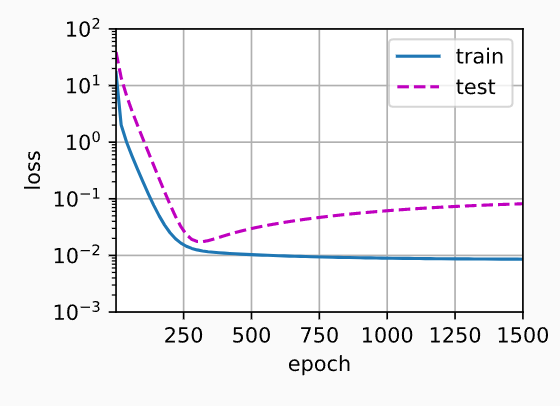

## Summary

*   Since the generalization error cannot be estimated based on the training error, simply minimizing the training error will not necessarily mean a reduction in the generalization error. Machine learning models need to be careful to safeguard against overfitting so as to minimize the generalization error.

*   Since the generalization error cannot be estimated based on the training error, simply minimizing the training error will not necessarily mean a reduction in the generalization error. Machine learning models need to be careful to safeguard against overfitting so as to minimize the generalization error.
*   Underfitting means that a model is not able to reduce the training error. When training error is much lower than validation error, there is overfitting.



*   We should choose an appropriately complex model and avoid using insufficient training samples

